In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pickle as pkl
import urllib.request # to fetch data online
import re # regular expressions to parse html
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

## Download/read data

In [26]:
# NIPS data in in ../data/papers.csv
bool_abstract_detected = False
bool_abstract_finished = False
nips_papers = []

tic = time.time()
with open("../data/papers.csv") as fin:
    lines = fin.readlines()
    for index, line in enumerate(lines):
        
        #print(line.split(','))
        
        if ".pdf," in line or "Abstract Missing" in line:
            # New entry detected, read paper id and year of publication
            line_split = line.split(',')
            paper_id = line_split[0]
            year = line_split[1]
        
        if bool_abstract_detected and not bool_abstract_finished:
            # Read new line of abstract and check whether it is the last one
            abstract += " "+line
            bool_abstract_finished = lines[index+1][-5:].isupper() or "Introduction" in lines[index+1]
            
        if bool_abstract_finished:
            # Save abstract and prepare for the next one
            paper = {}
            paper["id"] = paper_id
            paper["year"] = year
            paper["abstract"] = abstract
            nips_papers.append(paper)
            bool_abstract_detected = False
            bool_abstract_finished = False
        
        if line.startswith("ABSTRACT") or line.startswith("Abstract"):
            # New abstract starting next line
            abstract = ""
            bool_abstract_detected = True

toc = time.time()
number_of_papers = len(nips_papers)
print(str(number_of_papers)+" abstracts read in %0.3fs." % (toc-tic))

7234 abstracts read in 6.288s.


JMLR data has to be manually fetched

In [2]:
volume_numbers = range(1,20)
jmlr_papers = []
tic = time.time()
for volume_number in volume_numbers:
    print("Reading volume", str(volume_number))

    # Read page listing papers in given volume
    volume_url = "http://www.jmlr.org/papers/v"+str(volume_number)
    html = urllib.request.urlopen(volume_url)
    page = html.read().decode('utf-8')
    
    # Find urls of abstracts
    candidate_patterns = [r"<a href=(.*)>\[abs\]</a>", r"<a href=(.*)>abs</a>"]
    #candidate_patterns = [r"<a href=(.*)>\[abs\]</a>", r"<a href=\"(.*)\">abs</a>", r"<a href=(.*)>abs</a>", r"<a href=\'(.*)\'>abs</a>"]
    cpt_patterns = 0
    paper_pattern = candidate_patterns[cpt_patterns]
    while re.search(paper_pattern, page) == None:     
        cpt_patterns += 1
        paper_pattern = candidate_patterns[cpt_patterns]
    papers_matches = re.finditer(paper_pattern, page)

    # Read abstract
    cpt = 0
    for paper_match in papers_matches:
        cpt += 1
        paper_id = paper_match.group(1)
        paper_id = paper_id.split('/')[-1] # some issues have full urls, so just keep the trailing id
        paper_id = paper_id.replace('\"',"")
        paper_id = paper_id.replace('\'',"")                            
        abstract_url = volume_url+'/'+paper_id            
        #if paper_id.startswith("http"):
            # some issues have full urls, some local urls"
        #    abstract_url = paper_id
        #elif paper_id.startswith("/papers"):
        #    temp = paper_id.split("/")
        #    abstract_url = paper_id
        #else:
        #    abstract_url = volume_url+'/'+paper_id
        #print(abstract_url)
        try:
            abstract_html = urllib.request.urlopen(abstract_url)
            abstract_page = abstract_html.read().decode('utf-8')
            #print(abstract_page)
            abstract_pattern = re.compile(r"<h3>Abstract</h3>(.*)<font", re.DOTALL) # DOTALL allows . to match with newlines
            abstract_match = re.search(abstract_pattern, abstract_page) 
            #print(abstract_match)
            #abstracts_matches = re.finditer(abstract_pattern, abstract_page)
            #for abstract_match in abstracts_matches:
            paper = {}
            paper["volume"] = volume_number
            paper["abstract"] = abstract_match.group(1).replace("\n","") # also replace <p>
            jmlr_papers.append(paper)  
        except:
            print("Dead link:", abstract_url)
            pass
    print(cpt, "papers in volume", volume_number)

toc = time.time()
number_of_jmlr_papers = len(jmlr_papers)
print(number_of_jmlr_papers, "papers read in %0.3fs."%(toc - tic))

Reading volume 1
11 papers in volume 1
Reading volume 2
32 papers in volume 2
Reading volume 3
56 papers in volume 3
Reading volume 4
54 papers in volume 4
Reading volume 5
31 papers in volume 5
Reading volume 6
73 papers in volume 6
Reading volume 7
100 papers in volume 7
Reading volume 8
91 papers in volume 8
Reading volume 9
95 papers in volume 9
Reading volume 10
100 papers in volume 10
Reading volume 11
118 papers in volume 11
Reading volume 12
105 papers in volume 12
Reading volume 13
119 papers in volume 13
Reading volume 14
Dead link: http://www.jmlr.org/papers/v14/debrabanter13a.html
121 papers in volume 14
Reading volume 15
120 papers in volume 15
Reading volume 16
Dead link: http://www.jmlr.org/papers/v16/feldman15a.html
118 papers in volume 16
Reading volume 17
238 papers in volume 17
Reading volume 18
234 papers in volume 18
Reading volume 19
84 papers in volume 19
1898 papers read in 465.666s.


In [4]:
pkl.dump(jmlr_papers, open("jmlr.pkl","wb"))

## Read data

In [8]:
bayesian_jmlr_papers = []
neural_network_jmlr_papers = []
for paper in jmlr_papers:
    bayesian_keywords = ["Bayesian", "variational Bayes"]
    if any(kwd in paper["abstract"] for kwd in bayesian_keywords):
        bayesian_jmlr_papers.append(paper)
    neural_network_keywords = ["neural net", "Neural net", "deep", "Deep"]
    if any(kwd in paper["abstract"] for kwd in neural_network_keywords):
        neural_network_jmlr_papers.append(paper)
number_of_jmlr_papers = len(jmlr_papers)
number_of_Bayesian_jmlr_papers = len(bayesian_jmlr_papers)   
print("There are", str(len(neural_network_jmlr_papers))+" neural network papers out of", number_of_jmlr_papers)
print("There are", str(number_of_Bayesian_jmlr_papers)+" Bayesian papers out of", number_of_jmlr_papers)

There are 98 neural network papers out of 1898
There are 218 Bayesian papers out of 1898


In [10]:
# Bayesian networks may not be about Bayesian statistics
print("Out of which the number of papers about Bayesian networks is")
print(np.sum(["Bayesian network" in paper["abstract"] for paper in bayesian_jmlr_papers]))

Out of which the number of papers about Bayesian networks is
63


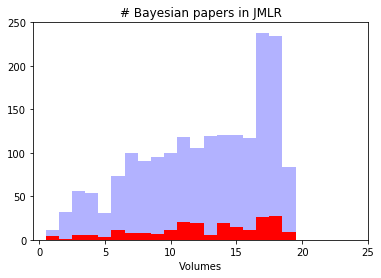

In [14]:
# plot proportion of Bayesian papers
volumes = [int(paper["volume"]) for paper in jmlr_papers] + [20]
bins = np.unique(volumes) - .5
plt.hist([int(paper["volume"]) for paper in jmlr_papers], color="blue", bins=bins, alpha=.3)
bins = np.unique([int(paper["volume"]) for paper in jmlr_papers] + [20]) - .5
plt.hist([int(paper["volume"]) for paper in bayesian_jmlr_papers], color="red", bins=bins)
plt.xticks([5*i for i in range(6)])
plt.xlabel("Volumes")
plt.title("# Bayesian papers in JMLR")
plt.show()



## Quick analysis of Bayesian papers at NIPS 1985--2017

In [29]:
bayesian_nips_papers = []
neural_network_nips_papers = []
for paper in nips_papers:
    bayesian_keywords = ["Bayesian", "variational Bayes"]
    if any(kwd in paper["abstract"] for kwd in bayesian_keywords):
        bayesian_nips_papers.append(paper)
    neural_network_keywords = ["neural network", "Neural network", "deep", "Deep"]
    if any(kwd in paper["abstract"] for kwd in neural_network_keywords):
        neural_network_nips_papers.append(paper)
number_of_Bayesian_nips_papers = len(bayesian_nips_papers)   
print("There are", str(len(neural_network_nips_papers))+" neural network papers out of", number_of_papers)
print("There are", str(number_of_Bayesian_nips_papers)+" Bayesian papers out of", number_of_papers)

There are 1063 neural network papers out of 7234
There are 699 Bayesian papers out of 7234


In [30]:
# Bayesian networks may not be about Bayesian statistics
print("Out of which the number of papers about Bayesian networks is")
print(np.sum(["Bayesian network" in paper["abstract"] for paper in bayesian_nips_papers]))

Out of which the number of papers about Bayesian networks is
53


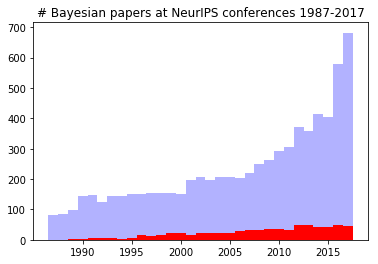

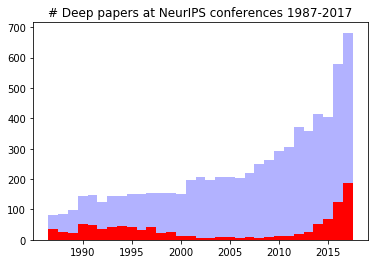

In [31]:
# plot proportion of Bayesian papers
years = [int(paper["year"]) for paper in nips_papers] + [2018]
bins = np.unique(years) - .5
plt.hist([int(paper["year"]) for paper in nips_papers], color="blue", bins=bins, alpha=.3)
bins = np.unique([int(paper["year"]) for paper in bayesian_nips_papers] + [2018]) - .5
plt.hist([int(paper["year"]) for paper in bayesian_nips_papers], color="red", bins=bins)
plt.xticks([1990+5*i for i in range(6)])
plt.title("# Bayesian papers at NeurIPS conferences 1987-2017")
plt.show()

# plot proportion of Bayesian papers
years = [int(paper["year"]) for paper in nips_papers] + [2018]
bins = np.unique(years) - .5
plt.hist([int(paper["year"]) for paper in nips_papers], color="blue", bins=bins, alpha=.3)
bins = np.unique([int(paper["year"]) for paper in neural_network_nips_papers] + [2018]) - .5
plt.hist([int(paper["year"]) for paper in neural_network_nips_papers], color="red", bins=bins)
plt.xticks([1990+5*i for i in range(6)])
plt.title("# Deep papers at NeurIPS conferences 1987-2017")
plt.show()

## Topic modelling

Let us first look at all JMLR

In [20]:
# Extract tf features (raw term counts)
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=1000,
                                stop_words='english') # output is a sparse matrix
tic = time.time()
tf = tf_vectorizer.fit_transform([paper["abstract"] for paper in jmlr_papers])
print("Extraction done in %0.3fs." % (time.time() - tic))

# Fit the LDA
number_of_topics = 10
lda = LatentDirichletAllocation(n_components=number_of_topics, max_iter=100,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
tic = time.time()
lda.fit(tf)
print("LDA fit done in %0.3fs." % (time.time() - tic))

done in 0.366s.


In [23]:
# Print top words in each topic
def print_top_words(model, feature_names, number_of_top_words=10):
    """print top words by topic in a given model
    """
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-number_of_top_words - 1:-1]])
        print(message)
    print()
       
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names)

Topic #0: matrix sparse rank norm low lasso matrices sparsity high problem
Topic #1: sub sup algorithm learning policy problem function methods tree method
Topic #2: learning data algorithms methods based problems paper training machine tasks
Topic #3: em graph network networks graphs structure nodes algorithm search graphical
Topic #4: algorithm gradient algorithms online al et stochastic regret boosting descent
Topic #5: nbsp href papers pdf font bib 17 100 right target
Topic #6: model models data bayesian inference variables markov gaussian process approach
Topic #7: bounds learning error loss results class bound function algorithms problem
Topic #8: log class learning epsilon mathcal complexity time queries classes small
Topic #9: data kernel method based kernels svm vector space clustering problem



Now only Bayesian papers

In [24]:
# Extract tf features (raw term counts)
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=1000,
                                stop_words='english') # output is a sparse matrix
tic = time.time()
tf = tf_vectorizer.fit_transform([paper["abstract"] for paper in bayesian_jmlr_papers])
print("Extraction done in %0.3fs." % (time.time() - tic))

# Fit the LDA
number_of_topics = 10
lda = LatentDirichletAllocation(n_components=number_of_topics, max_iter=100,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
tic = time.time()
lda.fit(tf)
print("LDA fit done in %0.3fs." % (time.time() - tic))

Extraction done in 0.047s.
LDA fit done in 3.637s.


In [25]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names)

Topic #0: activities state algorithm search structure algorithms network bayesian learning complexity
Topic #1: consensus annotators labels quality smaller quite motivated short control bias
Topic #2: workers labeling budget instances policy computationally quality problem allocation dp
Topic #3: bayesian learning criterion information network gp structure methods paper techniques
Topic #4: margin max topic models supervised multi prediction representations gibbs existing
Topic #5: topic vb lda matrix bayes variational field singular allocation shrinkage
Topic #6: learning bayesian networks models algorithms markov graphical model priors sup
Topic #7: bayesian data model learning models based inference methods algorithm method
Topic #8: clustering dirichlet prior grammar model process language natural pitman yor
Topic #9: nbsp posterior href papers 17 font bib pdf data inference



Now Bayesian papers in JMLR+NIPS

In [39]:
# Extract tf features (raw term counts)
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=1000,
                                stop_words='english') # output is a sparse matrix
tic = time.time()
tf = tf_vectorizer.fit_transform([paper["abstract"] for paper in bayesian_jmlr_papers+bayesian_nips_papers])
print("Extraction done in %0.3fs." % (time.time() - tic))

# Fit the LDA
number_of_topics = 20
lda = LatentDirichletAllocation(n_components=number_of_topics, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
tic = time.time()
lda.fit(tf)
print("LDA fit done in %0.3fs." % (time.time() - tic))

Extraction done in 0.152s.
LDA fit done in 3.381s.


In [40]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, number_of_top_words=10)

Topic #0: scheme computation combines elements takes involving continuous describes yields message
Topic #1: recently computational data property treatment sensory risk form sets known
Topic #2: model hierarchical inference networks hdp methods data algorithms information structure
Topic #3: markov monte carlo time mcmc chain inference sampling data em
Topic #4: learning techniques bounds gp methods distribution standard provide including free
Topic #5: 12 sparsity dependency average types bias improvement em accuracy text
Topic #6: data view learning training detection type produce model active algorithm
Topic #7: selection model ep convergence paper based bayes non features scheme
Topic #8: energy free subsets statistical minimum bayes family theoretical marginal based
Topic #9: model learning data method models based algorithm approach methods neural
Topic #10: model hierarchical models level dropout topic learning hierarchy instance lda
Topic #11: models data model process latent i